# Marina Lebedina
## ID: 12249127

# HW 6. FX Carry Strategy

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import functools
import quandl
quandl.ApiConfig.api_key = 'bWbMQmPczynWg63DzkA9'
from tqdm import tnrange
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.interpolate import interp1d
# %%javascript IPython.OutputArea.auto_scroll_threshold = 9999

# 1. Download data
## 1.1. Obtain yield curves

We are going to implement **weekly** FX Carry Trade strategy, and reference points will be **Wednesdays** $\Rightarrow$ download daily YC data from Quandl and filter it so that we have only Wednesdays in our dataset.

In [2]:
currencies_yc = ['THA', 'ROU', 'JPN', 'IDN']
currencies = ['THB', 'RON', 'JPY', 'IDR']

start = '2011-01-01'
end = '2020-05-12'

yc_data = {}
for i in tnrange(len(currencies_yc)):
    curr = currencies_yc[i]
    curr_new = currencies[i]
    raw_data = quandl.get('YC/{}'.format(curr), start_date=start, end_date=end, collapse='daily',
                          returns="pandas")
    raw_data.index = pd.to_datetime(raw_data.index)
    raw_data['day'] = raw_data.index.to_series().dt.dayofweek
    raw_data = raw_data[raw_data['day'] == 2] # use EVERY WEDNESDAY
    raw_data = raw_data.drop('day', axis=1)
    yc_data[curr_new] = raw_data  
    
yc_data['RON'] = yc_data['RON'].rename({'12-Month': '1-Year'}, axis=1)
yc_data['RON']['2-Year'] = np.nan
x = yc_data['RON'][['1-Year','2-Year','3-Year']].interpolate(axis=1)
yc_data['RON']['2-Year'] = x['2-Year']

raw_data.head(3)

,1-Year,2-Year,3-Year,4-Year,5-Year,6-Year,7-Year,8-Year,9-Year,10-Year,15-Year,20-Year,30-Year
Date,,,,,,,,,,,,,
2014-12-03,6.671,7.334,7.578,7.668,7.678,7.756,7.851,7.865,7.849,7.859,8.128,8.256,8.524
2014-12-10,6.845,7.364,7.631,7.736,7.802,7.859,7.935,7.984,8.003,7.985,8.253,8.397,8.663
2014-12-17,7.206,7.785,7.965,8.118,8.232,8.279,8.356,8.372,8.397,8.404,8.780,8.829,9.104


## 1.2. Obtain 3M Interbank rates

We will use the following Interbank Offered rates:

- **3M LIBOR** rate for **JPY** from quandl;

- 3M Bangkok Interbank Offered rate for **THB**, i.e. **3M BIBOR** from Bank of Thailand Official website: https://www.bot.or.th/app/bibor/publish/PublishSpecifyInstRate.aspx?Lang=ENG

- 3M Jakarta Interbank Offered Rate for **IND**, i.e. **3M JIBOR** from Bank of Indonesia Official website: https://www.bi.go.id/en/moneter/jibor/data-historis/Default.aspx

- 3M Romanis Interbank Offered Rate for **RON**, i.e. **3M ROBOR** from Bank of Romania Official website:
https://www.bnr.ro/Statistics-report-1124.aspx

### 1.2.1. BIBOR 3M (THB)

In [3]:
libor = {}
libor_thb = pd.read_csv('THB_3M.csv', skiprows=2, usecols=["Date",'Tenor_3 Month'])
libor_thb = libor_thb.set_index('Date')
libor_thb.index = pd.to_datetime(libor_thb.index)
libor_thb.sort_index(inplace=True)
libor_thb = libor_thb.rename({'Tenor_3 Month': 'LIBOR3M'}, axis=1)
libor_thb['LIBOR3M'] = pd.to_numeric(libor_thb['LIBOR3M'], errors='coerce')
libor['THB'] = libor_thb

### 1.2.2. JPY LIBOR 3M (JPY)

In [4]:
libor_jpy = pd.read_csv('JPY_3M.csv')
libor_jpy = libor_jpy.set_index('DATE')
libor_jpy = libor_jpy.rename({'JPY3MTD156N': 'LIBOR3M'}, axis=1)
libor_jpy.index = pd.to_datetime(libor_jpy.index)
libor_jpy['LIBOR3M'] = pd.to_numeric(libor_jpy['LIBOR3M'], errors='coerce')
libor_jpy = libor_jpy.fillna(method='ffill')
libor['JPY'] = libor_jpy

### 1.2.3. JIBOR 3M (IND)

In [5]:
libor_ind = pd.read_csv('IND_3M.csv', usecols=["Date",'3months'])
libor_ind = libor_ind.set_index('Date')
libor_ind.index = pd.to_datetime(libor_ind.index)
libor_ind.sort_index(inplace=True)
libor_ind = libor_ind.rename({'3months': 'LIBOR3M'}, axis=1)
libor_ind['LIBOR3M'] = pd.to_numeric(libor_ind['LIBOR3M'], errors='coerce')
libor_ind = libor_ind.replace(0, np.nan)
libor_ind = libor_ind.fillna(method='ffill')
libor['IDR'] = libor_ind

### 1.2.4. ROBOR 3M (RON)

In [6]:
libor_ron = pd.read_csv('RON_3M.csv', skiprows=5, usecols=["Date",'ROBOR 3M (% p.a.) BBZ_BOR3M'])
libor_ron = libor_ron.set_index('Date')
libor_ron.index = pd.to_datetime(libor_ron.index)
libor_ron.sort_index(inplace=True)
libor_ron = libor_ron.rename({'ROBOR 3M (% p.a.) BBZ_BOR3M': 'LIBOR3M'}, axis=1)
libor_ron['LIBOR3M'] = pd.to_numeric(libor_ron['LIBOR3M'], errors='coerce')
libor_ron = libor_ron.replace(0, np.nan)
libor_ron = libor_ron.fillna(method='ffill')
libor['RON'] = libor_ron

## 1.3. Obtain FX rates

In [7]:
fx_data = {}
for i in tnrange(len(currencies)):
    curr = currencies[i]
    raw_data = quandl.get('CUR/{}'.format(curr), start_date=start, end_date=end, returns="pandas")
    raw_data.index = pd.to_datetime(raw_data.index)
    fx_data[curr] = raw_data
    
# Rename and create a dataframe
fx_df = fx_data['JPY']
fx_df = fx_df.rename({'RATE': 'JPY'}, axis=1)
fx_df = fx_df.merge(fx_data['RON'], how='left', left_index=True, right_index=True)
fx_df = fx_df.rename({'RATE': 'RON'}, axis=1)
fx_df = fx_df.merge(fx_data['THB'], how='left', left_index=True, right_index=True)
fx_df = fx_df.rename({'RATE': 'THB'}, axis=1)
fx_df = fx_df.merge(fx_data['IDR'], how='left', left_index=True, right_index=True)
fx_df = fx_df.rename({'RATE': 'IDR'}, axis=1)

In [88]:
# Weekly difference in exchange rates
fx_df_w = fx_df.copy()
fx_df_w['day'] = fx_df_w.index.to_series().dt.dayofweek
fx_df_w = fx_df_w[fx_df_w['day'] == 2] # use EVERY WEDNESDAY
fx_df_w = fx_df_w.drop('day', axis=1)
fx_df_w = fx_df_w.diff()
fx_df_w = fx_df_w.dropna()

# 2. Convert Spot Curve into Zero-Coupon-Bond Curve and compute Bond Prices

In [8]:
def compute_zcb_curve(spot_rates_curve):
    period = 1/4 # quarterly
    maturities = []
    for i in range(len(spot_rates_curve.index.values)):
        num = int(spot_rates_curve.index.values[i].rsplit('-', 1)[0])
        per = spot_rates_curve.index.values[i].rsplit('-', 1)[1]
        if per == 'Month':
            matur = num/12
        else:
            matur = num
        maturities.append(matur)
    spot_rates_curve['matur'] = maturities
    spot_rates_curve.set_index('matur', inplace=True)
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor > 1/12: 
                times = np.arange(tenor-period, 0, step=-period)[::-1]
                coupon_half_yr = period*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

def bond_price(zcb, coupon_rate, tenor):
    period = 1/4
    times = np.arange(tenor, 0, step=-period)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, np.array(zcb.values).T[0]) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + period * coupon_rate * np.exp(-r*times).sum()
    return p

In [9]:
zcb_data = {}
zb_data = {}
zb_1w_data = {}

for i in tnrange(len(currencies)):
    curr = currencies[i]
    df = pd.DataFrame(index=yc_data[curr].index.values, columns=yc_data[curr].columns.values)
    df_1w = pd.DataFrame(index=yc_data[curr].index.values, columns=yc_data[curr].columns.values)
    for j in range(1, yc_data[curr].shape[0]):
        t_idx_prev = yc_data[curr].index[j-1]
        t_idx_curr = yc_data[curr].index[j]
        t_prev = pd.DataFrame(yc_data[curr].loc[t_idx_prev]) / 100
        t_curr = pd.DataFrame(yc_data[curr].loc[t_idx_curr]) / 100
        zcb_prev = compute_zcb_curve(t_prev)
        zcb_curr = compute_zcb_curve(t_curr)
        for k in range(zcb_prev.shape[0]):
            tenor = zcb_prev.index[k]
            tenor_1w = tenor - 1/52
            col = yc_data[curr].columns.values[k]
            coupon = yc_data[curr].loc[t_idx_prev, col] / 100
            bp = bond_price(zcb_prev, coupon, tenor)
            bp_1w = bond_price(zcb_curr, coupon, tenor_1w)
            df.loc[t_idx_prev, col] = bp
            df_1w.loc[t_idx_prev, col] = bp_1w
    zb_data[curr] = df
    zb_1w_data[curr] = df_1w

In [10]:
# zb_data['THB'].head(3)

In [11]:
# zb_1w_data['THB'].head(3)

# 3. FX Carry Trade implementation

## 3.1. Signals generation

We are using **5Y swap rates** for generation of trading signals:

$$ Y_i(5y) - Y_j(5y) > 50 bp \Rightarrow \text{ borrow in } j \text{, lend in } i $$

$$ Y_i(5y) - Y_j(5y) < -50 bp \Rightarrow \text{ borrow in } i \text{, lend in } j $$

$$ Y_i(5y) - Y_j(5y) \in [-50 bp, 50 bp]  \Rightarrow \text{ no signal } $$

As we can see from the ***plot "Dynamics of 5-year yields"***, wherever we consider **JPY** as one of the currencies in currency pair, it will definitely be a **borrowing currency** as it has the lowest yield, and thus, we will never use JPY as a lending currency. At the same time **IDR** has the highest yield, and it will always be a **lending currency** wherever we consider it as one of the currencies in the currency pair.

**Borrowing** will mostly be done in **JPY** and **THB**.

**Lending** will mostly be done in **IDR** and **RON**.

As we can see from the ***plot "Dynamics of exchange rates"*** **USD** will **appreciate** in terms of all the currencies (RON, IDR, THB and JPY) with the passage of time. We would lock a loss due to this exchange rates dynamics in case we hold our positions for longer horizons, however we are implementing **weekly trading** and that is why we **won't be able to take a full disadvantage of USD appreciation**, but will take only a part of it due to investment horizon restrictions or not to take at all due to intraweeks exchange rates fluctutions. We can see from the ***plot "Dynamics of weekly difference of exchange rates"*** that there is no upward or downward trend in weekly exchange rates dynamics for all currencies. Thus, we can not definitely attribute our profits or losses to exchange rates trends.

We can see from the ***plot "Dynamics of difference b/t 5y yields"*** that the absolute difference b/t almost all currencies yields is greater than 50 bp, which means that we **will open positions for the pairs JPY/RON, JPY/THB, JPY/IDR, RON/IDR, THB/IDR every week**, however for the pair **RON/THB** we won't have weekly opened positions as the spread b/t 5y yields corresponding to those currencies is less than 50 bp in absolute sense for half a period under consideration.

- Capital owned = $2,000,000

- Capital borrowed = $8,000,000

- Capital invested = $10,000,000


If borrowing currency is **j** and lending currency is **i** $\Rightarrow$ 

1) **at time $t_0$**, i.e. Wednesday of week $t_0$:

- borrow equivalent of \$8,000,000 in **j**, i.e. borrow $ \$8,000,000 \cdot FX^j_0 $ of **j-currency**


- buy equivalent of \$10,000,000 of **i-currency** T-year bonds, i.e. buy $ \frac{\$10,000,000 \cdot FX^i_0}{ B_0^i} $number of bonds (we will compare **"floor" and "ceiling" roundings of the number of bonds** following the assumption that we can't trade fractional number of bonds, as well as not-rounded number of bonds)

2) **at time $t_1$**, i.e. Wednesday of week $t_1$, where $t_1 - t_0 = $ 1 week:

- return borrowed amount with interest, i.e. return $\frac{ \$8,000,000 \cdot FX^j_0  \cdot ( 1 + LIBOR_0^j + 50bp)}{FX^j_1}$ (in USD equivalent)


- sell $ \frac{\$10,000,000 * FX^i_0}{ B_0^i} $ number of bonds for $B_1^i \Rightarrow$ get $ \frac{\$10,000,000 \cdot FX^i_0 \cdot B_1^i}{ B_0^i \cdot FX^i_1} $ in USD


- **calculate PnL** as $\$8,000,000 - \frac{ \$8,000,000 \cdot FX^j_0  \cdot ( 1 + LIBOR_0^j + 50bp)}{FX^j_1} - \$10,000,000 + \frac{\$10,000,000 \cdot FX^i_0 \cdot B_1^i}{ B_0^i \cdot FX^i_1} $

**Performance of FX Carry strategy** will be assessed based on:
- **Cumulative PnL**;

- **Annualized Return**;

- **Sharpe Ratio** = $ \frac{E(r - r_f)}{\sqrt{E[(r-r_b)^2]}} $;

- **Sortino Ratio** = $ \frac{E(r - r_b)}{\sqrt{E[ (r-r_b)^2 | r < r_b ]}} $

FX Carry Strategy performance of the following **different combinations of parameters** will be combared: 

- THB, RON, IDR vs JPY currency pairs and all 6 combinations of pairs traded together;

- different bond tenors, i.e. 1, 2, 3, 5-year tenors;

- different number of bonds bought, i.e. different rounding: "floor", "ceiling", "no rounding - fractional".

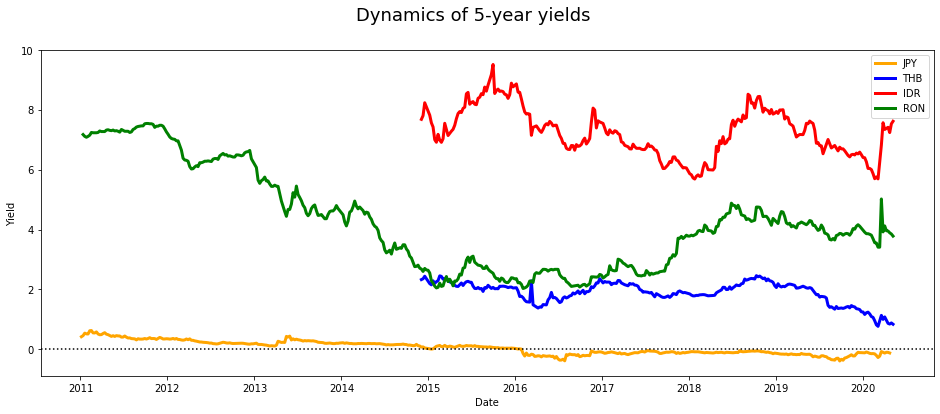

In [12]:
fig, ax1 = plt.subplots(figsize=(16,6))

ax1.plot(yc_data['JPY'][['5-Year']], color='orange', linewidth=3, label='JPY', linestyle='-')
ax1.plot(yc_data['THB'][['5-Year']], color='blue',   linewidth=3, label='THB', linestyle='-')
ax1.plot(yc_data['IDR'][['5-Year']], color='red',    linewidth=3, label='IDR', linestyle='-')
ax1.plot(yc_data['RON'][['5-Year']], color='green',  linewidth=3, label='RON', linestyle='-')
ax1.axhline(y=0, color='black', linestyle=':')

ax1.legend(loc=0)
ax1.set_xlabel('Date')
ax1.set_ylabel('Yield', color='black')

plt.suptitle('Dynamics of 5-year yields', fontsize=18)
None

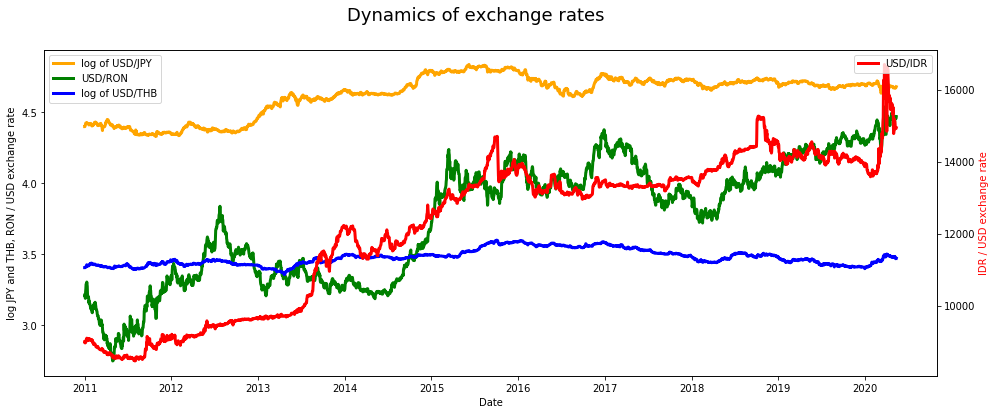

In [13]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax2 = ax1.twinx()

ax1.plot(np.log(fx_df['JPY']), color='orange', linewidth=3, label='log of USD/JPY')
ax1.plot(fx_df['RON'], color='green', linewidth=3, label='USD/RON')
ax1.plot(np.log(fx_df['THB']), color='blue', linewidth=3, label='log of USD/THB')
ax2.plot(fx_df['IDR'], color='red', linewidth=3, label='USD/IDR')
ax1.legend(loc=0)
ax2.legend(loc=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('log JPY and THB, RON / USD exchange rate', color='black')
ax2.set_ylabel('IDR / USD exchange rate', color='red')

plt.suptitle('Dynamics of exchange rates', fontsize=18)
None

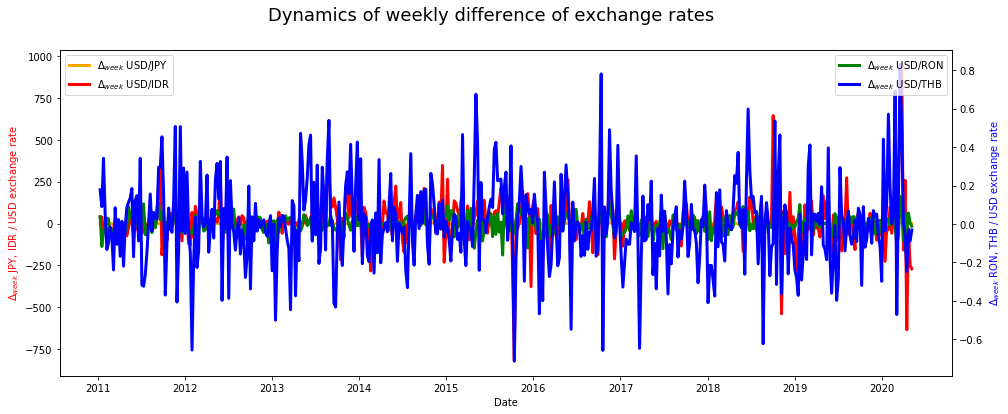

In [95]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax2 = ax1.twinx()

ax1.plot(fx_df_w['JPY'], color='orange', linewidth=3, label='$\Delta_{week}$ USD/JPY')
ax2.plot(fx_df_w['RON'], color='green', linewidth=3, label='$\Delta_{week}$ USD/RON')
ax2.plot(fx_df_w['THB'], color='blue', linewidth=3, label='$\Delta_{week}$ USD/THB')
ax1.plot(fx_df_w['IDR'], color='red', linewidth=3, label='$\Delta_{week}$ USD/IDR')
ax1.legend(loc=0)
ax2.legend(loc=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('$\Delta_{week}$ JPY, IDR / USD exchange rate', color='red')
ax2.set_ylabel('$\Delta_{week}$ RON, THB / USD exchange rate', color='blue')

plt.suptitle('Dynamics of weekly difference of exchange rates', fontsize=18)
None

In [14]:
def calc_diff(data, term, diff_indices):
    
    yc_df = yc_data['JPY'][[term]]
    yc_df = yc_df.rename({term: 'JPY'}, axis=1)

    yc_df = yc_df.merge(yc_data['RON'][[term]], how='left', left_index=True, right_index=True)
    yc_df = yc_df.rename({term: 'RON'}, axis=1)

    yc_df = yc_df.merge(yc_data['THB'][[term]], how='left', left_index=True, right_index=True)
    yc_df = yc_df.rename({term: 'THB'}, axis=1)

    yc_df = yc_df.merge(yc_data['IDR'][[term]], how='left', left_index=True, right_index=True)
    yc_df = yc_df.rename({term: 'IDR'}, axis=1)

#     diff_indices = ['JPY_RON', 'JPY_THB', 'JPY_IDR', 'RON_THB', 'RON_IDR', 'THB_IDR']

    for i in range(len(diff_indices)):
        idx = diff_indices[i]
        curr1 = idx[:3]
        curr2 = idx[4:]
        yc_df[idx] = (yc_df[curr1] - yc_df[curr2])*100 # in basis points (times 100 => convert to basis points)

    diff = yc_df[diff_indices].dropna(how='all')
    
    return diff

term = '5-Year'
diff = calc_diff(yc_data, term, ['JPY_RON', 'JPY_THB', 'JPY_IDR', 'RON_THB', 'RON_IDR', 'THB_IDR'])

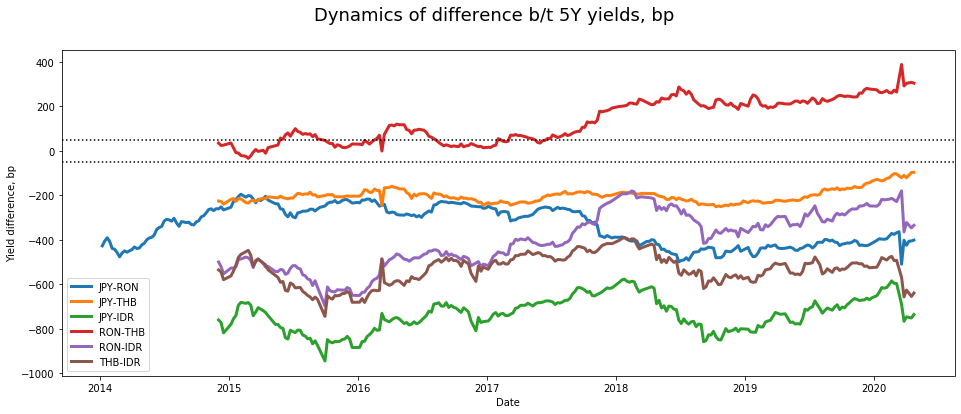

In [15]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(diff[diff.index > '2014-01-01']['JPY_RON'].dropna(), linewidth=3, label='JPY-RON', linestyle='-')
ax1.plot(diff[diff.index > '2014-01-01']['JPY_THB'].dropna(), linewidth=3, label='JPY-THB', linestyle='-')
ax1.plot(diff[diff.index > '2014-01-01']['JPY_IDR'].dropna(), linewidth=3, label='JPY-IDR', linestyle='-')
ax1.plot(diff[diff.index > '2014-01-01']['RON_THB'].dropna(), linewidth=3, label='RON-THB', linestyle='-')
ax1.plot(diff[diff.index > '2014-01-01']['RON_IDR'].dropna(), linewidth=3, label='RON-IDR', linestyle='-')
ax1.plot(diff[diff.index > '2014-01-01']['THB_IDR'].dropna(), linewidth=3, label='THB-IDR', linestyle='-')
ax1.axhline(y=50, color='black', linestyle=':')
ax1.axhline(y=-50, color='black', linestyle=':')
ax1.legend()
plt.suptitle('Dynamics of difference b/t 5Y yields, bp', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Yield difference, bp')
None

In [20]:
def signals_gen(pairs, diff, term, zb_data):
    indices = []  
        
    currencies = ['THB', 'RON', 'JPY', 'IDR']

    for i in range(len(currencies)):
        curr = currencies[i]
        idx1 = curr + '_B'
        idx2 = curr + '_L'
        idx3 = curr + '_size'
        indices.append(idx1)
        indices.append(idx3)
        indices.append(idx2)
    indices.append('USD_B')
    indices.append('USD_L')
    cf_df = pd.DataFrame(0.0, index=diff.index, columns=indices)
    mult = 1000000
    K_borrow = 8
    K_own = 2
    K_lend = K_borrow + K_own
    for i in range(diff.shape[0]):
        idx = diff.index[i]
        borrow = dict.fromkeys(currencies, 0) 
        lend = dict.fromkeys(currencies, 0) 
        for j in range(diff.shape[1]):
            pair = diff.columns[j]
            if diff.loc[idx, pair] > 50:
                curr_lend = pair[:3]
                curr_borr = pair[4:]
                try:
                    zb_rate = zb_data[curr_lend].loc[idx, term]
                except:
                    zb_rate = 0
                if zb_rate != 0:
                    borrow[curr_borr] += 1
                    lend[curr_lend] += 1
            elif diff.loc[idx, pair] < -50:
                curr_borr = pair[:3]
                curr_lend = pair[4:]
                try:
                    zb_rate = zb_data[curr_lend].loc[idx, term]
                except:
                    zb_rate = 0
                if zb_rate != 0:
                    borrow[curr_borr] += 1
                    lend[curr_lend] += 1
        for key, val in borrow.items():
            idx_b = key + "_B"
            cf_df.loc[idx, idx_b] += K_borrow*val
        for key, val in lend.items():
            idx_l = key + "_L"
            cf_df.loc[idx, idx_l] += K_lend *val  
    return cf_df

def cf_df_t0_calc(cf_df, zb_data, fx_df, rounding, term):
    for i in range(cf_df.shape[0]):
        idx = cf_df.index[i]
        for j in range(0, cf_df.shape[1]-2, 3):
            curr = cf_df.columns[j][:3]
            curr_b = curr + '_B'
            curr_l = curr + '_L'
            curr_size = curr + '_size'
            fx_rate = fx_df.loc[idx, curr]
            # LENDING (buy bonds)
            if cf_df.loc[idx, curr_l] != 0.0:
                try:
                    zb_rate = zb_data[curr].loc[idx, term]
                except:
                    zb_rate = 0
                if zb_rate != 0:
                    cf_df.loc[idx, 'USD_L'] -= cf_df.loc[idx, curr_l]
                    cf_df.loc[idx, curr_size] = (cf_df.loc[idx, curr_l] * fx_rate) / zb_rate
                    ####################### NUMBER OF BONDS TO BUY #######################
                    if rounding == "frac":
                         cf_df.loc[idx, curr_size] =  cf_df.loc[idx, curr_size]
                    elif rounding == "ceil":
                        cf_df.loc[idx, curr_size] = math.ceil(cf_df.loc[idx, curr_size])
                    elif rounding == 'floor':
                        cf_df.loc[idx, curr_size] = round(cf_df.loc[idx, curr_size])
                    #####################################################################
                    cf_df.loc[idx, curr_l] = -cf_df.loc[idx, curr_size] * zb_rate 
                else:
                    cf_df.loc[idx, curr_size] = 0
                    cf_df.loc[idx, curr_l] = 0
            # BORROWING
            if cf_df.loc[idx, curr_b] != 0.0:
                cf_df.loc[idx, 'USD_B'] += cf_df.loc[idx, curr_b]
                cf_df.loc[idx, curr_b] = cf_df.loc[idx, curr_b] * fx_rate  
    return cf_df

def cf_df_t1_calc(diff, cf_df, fx_df, zb_data, libor, term):
    cf_df_t1 = pd.DataFrame(0.0, index=diff.index, columns=cf_df.columns.values)
    for i in range(cf_df_t1.shape[0]-1):
        idx_prev = cf_df_t1.index[i]
        idx = cf_df_t1.index[i+1]
        for j in range(0, cf_df.shape[1]-2, 3):
            curr = cf_df.columns[j][:3]
            curr_b = curr + '_B'
            curr_l = curr + '_L'
            curr_size = curr + '_size'
            fx_rate = fx_df.loc[idx, curr] # t1 exchange rate
            # LENDING
            if cf_df.loc[idx_prev, curr_l] != 0: 
                cf_df_t1.loc[idx, curr_size] = cf_df.loc[idx_prev, curr_size]                
                zb_rate = zb_data[curr].loc[idx_prev, term] # t1 bond price 
                sell_bonds = cf_df.loc[idx_prev, curr_size] * zb_rate # value in FX
                sell_bonds_usd = sell_bonds / fx_rate # value in USD
                cf_df_t1.loc[idx, curr_l] = sell_bonds
                cf_df_t1.loc[idx, 'USD_L'] += sell_bonds_usd
            # BORROWING
            if cf_df.loc[idx, curr_b] != 0:
                amount_b = cf_df.loc[idx_prev, curr_b] # amount borrowed in FX
                mask = libor[curr].iloc[abs(libor[curr].index - idx_prev).argsort()]
                mask = mask[mask.index < idx_prev]
                libor_rate_idx = mask.index[0]
                libor_rate = libor[curr].loc[libor_rate_idx, 'LIBOR3M']
                cum_rate = ((libor_rate/100 + 50/100) / 100) * (7/360) # in decimals
                interest = amount_b * cum_rate
                total_due = interest + amount_b 
                cf_df_t1.loc[idx, curr_b] -= total_due # total due in FX
                cf_df_t1.loc[idx, 'USD_B'] = -total_due / fx_rate
    return cf_df_t1

def trading(term, rounding, currencies, yc_data, zb_data, zb_1w_data, fx_df, libor):
    diff = calc_diff(yc_data, term, currencies)
    signal_df = signals_gen(currencies, diff, term, zb_data)
    cf_df_t0 = cf_df_t0_calc(signal_df, zb_data, fx_df, rounding, term)
    cf_df_t1 = cf_df_t1_calc(diff, cf_df_t0, fx_df, zb_1w_data, libor, term)
    df_res = cf_df_t0.shift(1) + cf_df_t1
    df_res = df_res.dropna()
    df_res['PnL_USD'] = df_res['USD_B'] + df_res['USD_L']
    df_res['WkR_USD'] = df_res['PnL_USD'] / 2
    df_res['AnR_USD'] = (1+df_res['WkR_USD'])**(365/7)
    df_res['PnL_RON'] = df_res['RON_B'] + df_res['RON_L']
    df_res['PnL_THB'] = df_res['THB_B'] + df_res['THB_L']
    df_res['PnL_IDR'] = df_res['IDR_B'] + df_res['IDR_L']
    
    if df_res['WkR_USD'].std() != 0:
        SR = df_res['WkR_USD'].mean() / df_res['WkR_USD'].std()
    else:
        SR = 0
    if (df_res[df_res['WkR_USD'] < 0]['WkR_USD']).std() != 0:
        SoR = df_res['WkR_USD'].mean() / (df_res[df_res['WkR_USD'] < 0]['WkR_USD']).std()
    else:
        SoR = 0
    WR = df_res['WkR_USD'].mean()
    AR = df_res['AnR_USD'].mean()
    PnL_USD = df_res['PnL_USD'].sum()
    PnL_RON = df_res['PnL_RON'].sum()
    PnL_THB = df_res['PnL_THB'].sum()
    PnL_IDR = df_res['PnL_IDR'].sum()
    
    return df_res, SR, SoR, WR, AR, PnL_USD, PnL_RON, PnL_THB, PnL_IDR

In [51]:
tenors = ['1-Year', '2-Year', '3-Year', '5-Year']
fractions = ['frac', 'ceil', 'floor']
pairs = [['JPY_RON'], ['JPY_THB'], ['JPY_IDR'], ['RON_THB'], ['RON_IDR'], ['THB_IDR'], \
         ['JPY_RON', 'JPY_THB', 'JPY_IDR'], \
         ['JPY_RON', 'JPY_THB', 'JPY_IDR', 'RON_THB', 'RON_IDR', 'THB_IDR']]

indices = []
for p in range(len(pairs)):
    pair = pairs[p]
    for t in range(len(tenors)):
        tenor = tenors[t]
        for f in range(len(fractions)):
            frac = fractions[f]
            idx = str(pair) + "_" + str(tenor) + "_" + str(frac)
            indices.append(idx)
            
stat_dict = {}
stat_df = pd.DataFrame(index=indices, \
    columns=['Cum_PnL_USD', 'Cum_PnL_RON', 'Cum_PnL_THB', 'Cum_PnL_IDR', 'Wk_ret', 'An_ret', 'SR', 'SoR'])

for p in tnrange(len(pairs)):
    pair = pairs[p]
    for t in tnrange(len(tenors)):
        tenor = tenors[t]
        for f in range(len(fractions)):
            rounding = fractions[f]
            idx = str(pair) + "_" + str(tenor) + "_" + str(rounding)
            df_, SR_, SoR_, WR_, AR_, PnL_USD_, PnL_RON_, PnL_THB_, PnL_IDR_ = \
                trading(tenor, rounding, pair, yc_data, zb_data, zb_1w_data, fx_df, libor)
#             print(idx, PnL_USD_, PnL_RON_, PnL_THB_, PnL_IDR_)
            stat_df.loc[idx, 'SR'] = SR_
            stat_df.loc[idx, 'SoR'] = SoR_
            stat_df.loc[idx, 'Wk_ret'] = WR_
            stat_df.loc[idx, 'An_ret'] = AR_
            stat_df.loc[idx, 'Cum_PnL_USD'] = PnL_USD_
            stat_df.loc[idx, 'Cum_PnL_RON'] = PnL_RON_
            stat_df.loc[idx, 'Cum_PnL_THB'] = PnL_THB_
            stat_df.loc[idx, 'Cum_PnL_IDR'] = PnL_IDR_
            stat_dict[str(pair)] = df_

In [102]:
def plot_pnl(source, title):
    fig, ax1 = plt.subplots(figsize=(16,4))
    xaxis = ['1y', '1yc', '1yf', '2y', '2yc', '2yf', '3y', '3yc', '3yf', '5y', '5yc', '5yf']
    ax1.bar(xaxis, source['Cum_PnL_USD'].values, color='blue')
    ax1.set_xlabel('Parameters')
    ax1.set_ylabel('Cumulative PnL, MM USD $', color='black')
    plt.suptitle(title, fontsize=18)
    None
    
def plot_stat(data, measure, label, title):
    fig, ax1 = plt.subplots(figsize=(16,4))
    ax1.plot(data[[measure]], color='blue', linewidth=3)
    ax1.set_xlabel(' individual pairs <----- Parameters -----> portfolio (3 pairs) ----> portfolio (6 pairs)')
    ax1.set_ylabel(label, color='black')
    plt.xticks([])
    plt.suptitle(title, fontsize=18)
    None
    
def plot_rates(curr1, curr2):
    fig, ax1 = plt.subplots(figsize=(16,4))
    ax2 = ax1.twinx()
    ax1.plot(zb_1w_data[curr1]['1-Year'], label='{} 1-Year'.format(curr1), linewidth=2, linestyle='-', alpha=0.6) 
    ax1.plot(zb_1w_data[curr1]['2-Year'], label='{} 2-Year'.format(curr1), linewidth=2, linestyle='-', alpha=0.6)
    ax1.plot(zb_1w_data[curr1]['3-Year'], label='{} 3-Year'.format(curr1), linewidth=2, linestyle='-', alpha=0.6)
    ax1.plot(zb_1w_data[curr1]['5-Year'], label='{} 5-Year'.format(curr1), linewidth=2, linestyle='-', alpha=0.6)
    ax2.plot(libor[curr2], label='{} Interbank Offered Rate 3M'.format(curr2), linewidth=2, color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('{} Bond prices'.format(curr1), color='black')
    ax2.set_ylabel('{} Interbank Offered Rate, %'.format(curr2), color='black')
    ax1.legend(loc=0)
    ax2.legend(loc=2)
    plt.suptitle('{} bond prices vs. {} Interbank Offered Rate'.format(curr1, curr2), fontsize=16)
    
def plot_fx(curr1, curr2):
    fig, ax1 = plt.subplots(figsize=(16,4))
    ax2 = ax1.twinx()
    ax1.plot(fx_data[curr1], label='{} FX rate'.format(curr1), color='blue', linewidth=2)
    ax2.plot(fx_data[curr2], label='{} FX rate'.format(curr2), color='orange', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('{} FX rate'.format(curr1), color='blue')
    ax2.set_ylabel('{} FX rate'.format(curr2), color='orange')
    ax1.legend(loc=0)
    ax2.legend(loc=2)
    plt.suptitle('{}, {} / USD exchange rates'.format(curr1, curr2), fontsize=16)
    
    fig, ax1 = plt.subplots(figsize=(16,4))
    ax2 = ax1.twinx()
    ax1.plot(fx_df_w[curr1], label='$\Delta_w$ {} FX rate'.format(curr1), color='blue', linewidth=2)
    ax2.plot(fx_df_w[curr2], label='$\Delta_w$ {} FX rate'.format(curr2), color='orange', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('$\Delta_w$ {} FX rate'.format(curr1), color='blue')
    ax2.set_ylabel('$\Delta_w$ {} FX rate'.format(curr2), color='orange')
    ax1.legend(loc=0)
    ax2.legend(loc=2)
    plt.suptitle('$\Delta_w$ {}, {} / USD exchange rates'.format(curr1, curr2), fontsize=16)

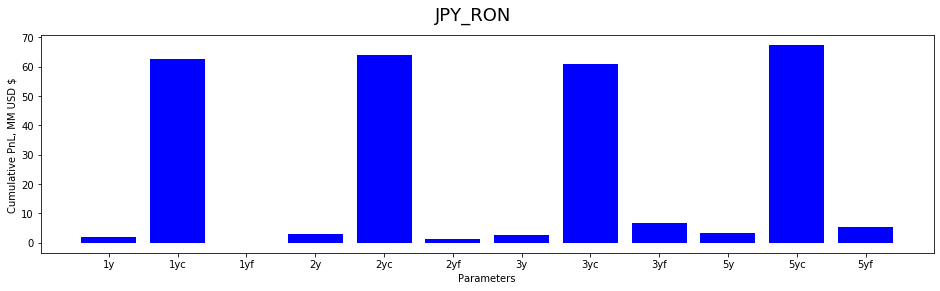

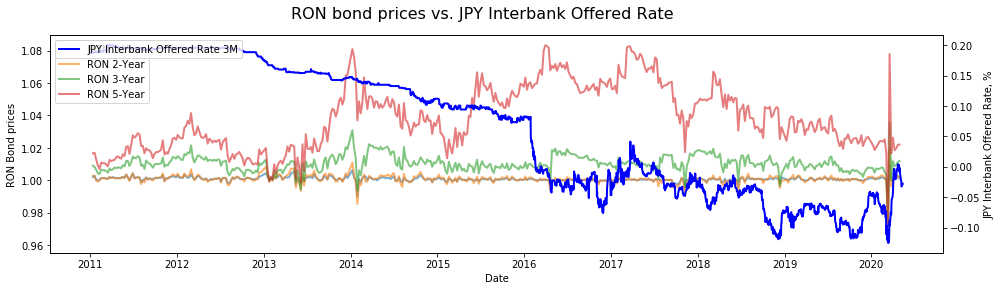

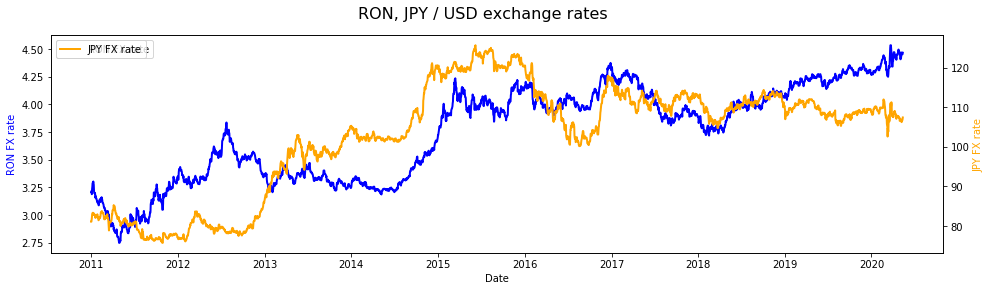

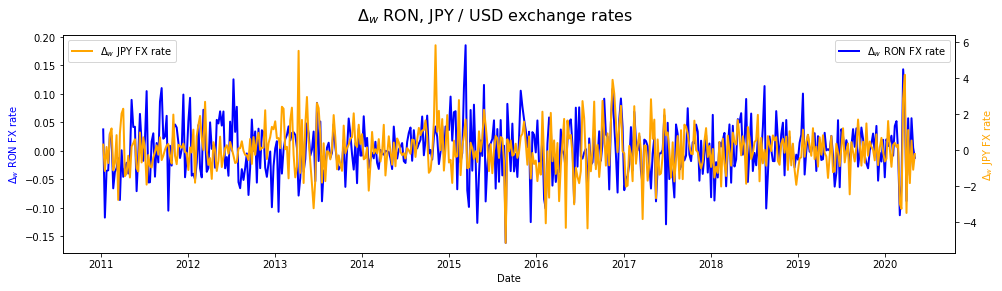

In [103]:
df_ = stat_df[0:0+12]
name = df_[:12].index.values[0][2:9]
plot_pnl(df_[:12], name)

plot_rates('RON', 'JPY')
plot_fx('RON', 'JPY')

Let us consider each currency pair separately, and then consider their combinations.

As we can see from the graphs above the **mean highest cumulative PnL** was achieved when trading **5-year bonds** issued by Romanian government. We can see that **USD has significantly appreciated in terms of both RON and JPY** during the investment period, however at the same time we can see that there is no trend of USD appreciation or depreciation in terms of 1-week exchange rates dynamics, thus appreciation of USD don't lead to losses generation. We see a lot of volatility in weekly exchange rates dynamics. This explains a high volatility of daily cumulative PnL.

At the same time we can see that high profits are also due to increase in RON bond prices, especially for 5y tenor. It coincides with the fact that according to the bar plot the highest PnL was achieved exactly when trading 5-year RON bonds. 

$$\Downarrow$$

**Contribution to profits:**

- Increase in RON Bond Prices, i.e. decrease in yields

- Fixed-float rates spread

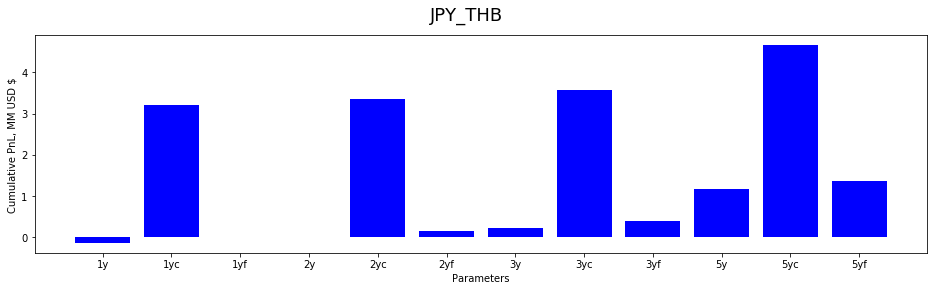

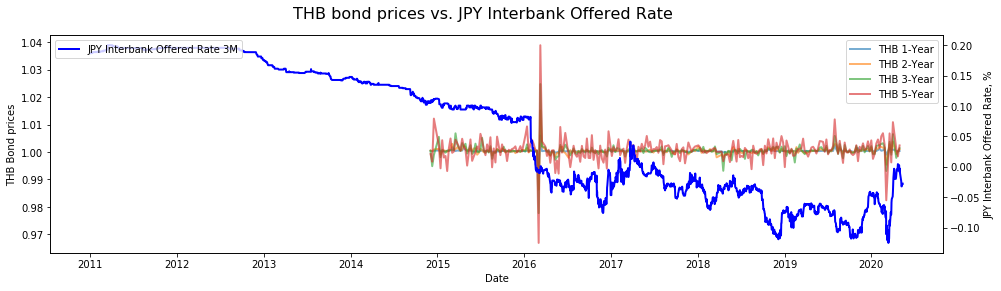

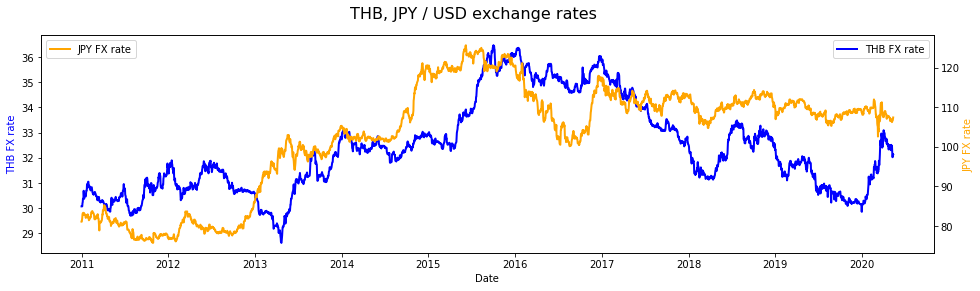

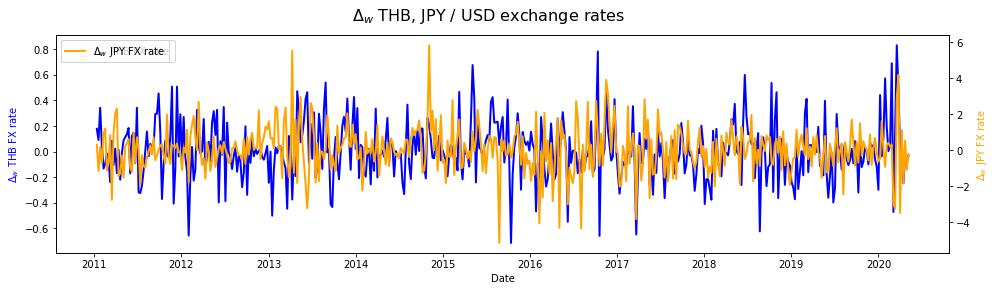

In [109]:
df_ = stat_df[12:12+12]
name = df_[:12].index.values[0][2:9]
plot_pnl(df_[:12], name)

plot_rates('THB', 'JPY')
plot_fx('THB', 'JPY')

As we can see from the graphs above the **mean highest cumulative PnL** was achieved when trading **5-year bonds** issued by Thailand government. This is due to the fact that **USD has moderately appreciated in terms of THB and significantly appreciated in terms of JPY** during the investment period, however at the same time we can see that there is no trend of USD appreciation or depreciation in terms of 1-week exchange rates dynamics, thus appreciation of USD don't lead to losses generation. We see a lot of volatility in weekly exchange rates dynamics. This explains a high volatility of daily cumulative PnL.

There were no significant appreciation in THB bond prices during the investment period.

$$\Downarrow$$

**Contribution to profits:**

- Appreciation of USD

- Fixed-float rates spread

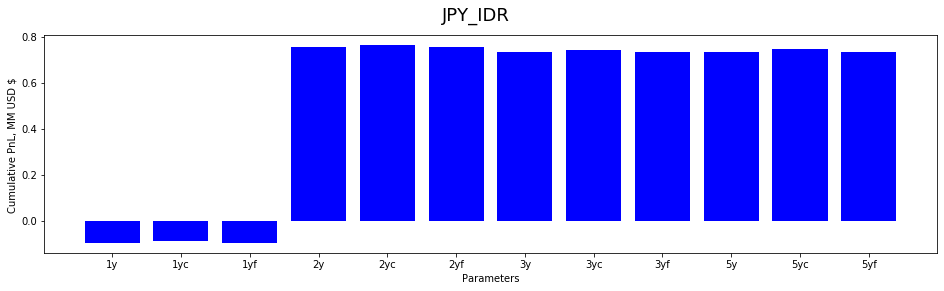

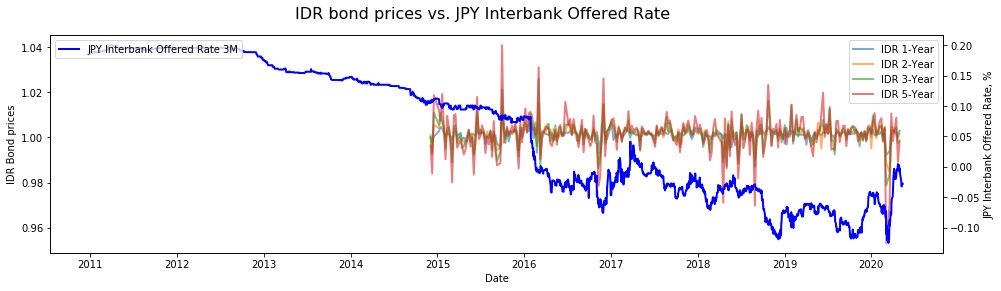

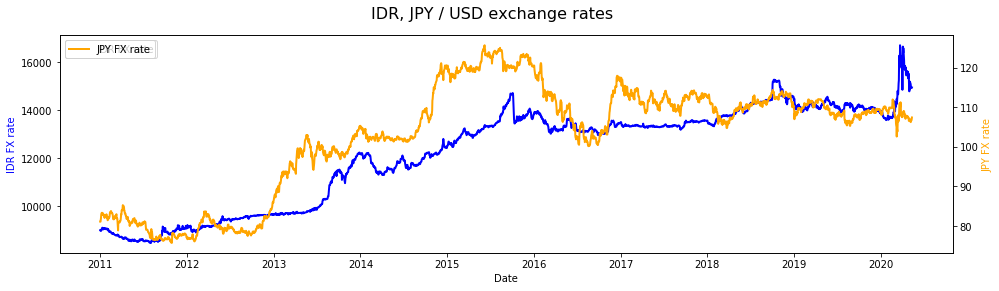

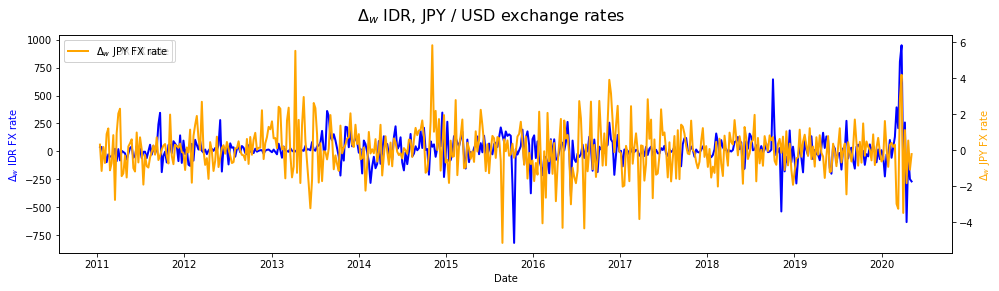

In [105]:
df_ = stat_df[24:24+12]
name = df_[:12].index.values[0][2:9]
plot_pnl(df_[:12], name)

plot_rates('IDR', 'JPY')
plot_fx('IDR', 'JPY')

As we can see from the graphs above the **mean highest cumulative PnL** was achieved when trading **2, 3 or 5-year bonds** issued by Indonesian government. This is due to the fact that **USD has significantly appreciated in terms of both IDR and JPY** during the investment period, however at the same time we can see that there is no trend of USD appreciation or depreciation in terms of 1-week exchange rates dynamics, thus appreciation of USD don't lead to losses generation. We see a lot of volatility in weekly exchange rates dynamics. This explains a high volatility of daily cumulative PnL.

There were no significant appreciation in IDR bond prices during the investment period.

$$\Downarrow$$

**Contribution to profits:**

- Fixed-float rates spread

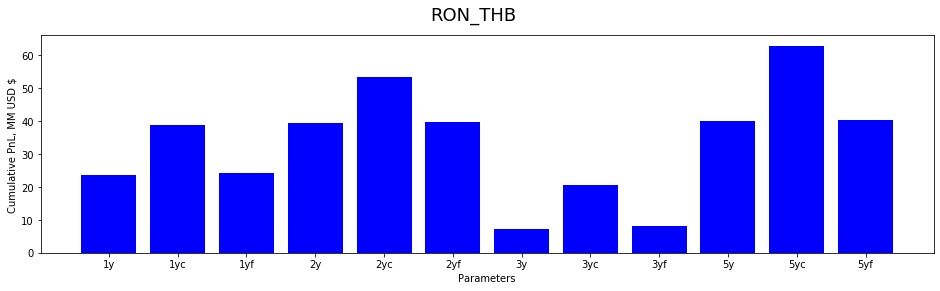

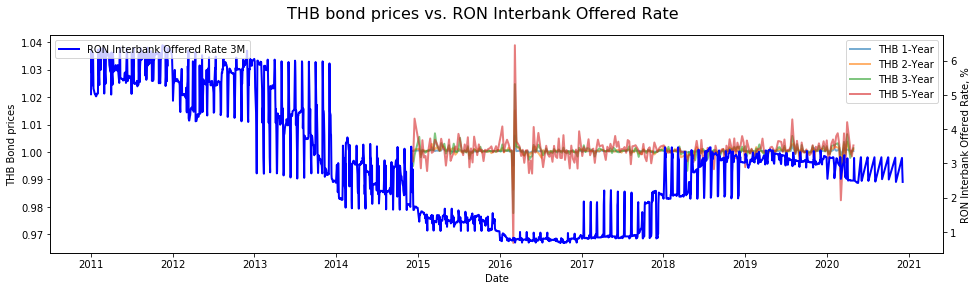

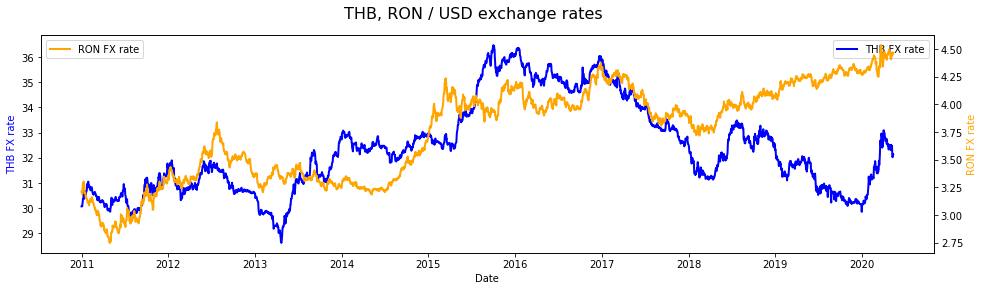

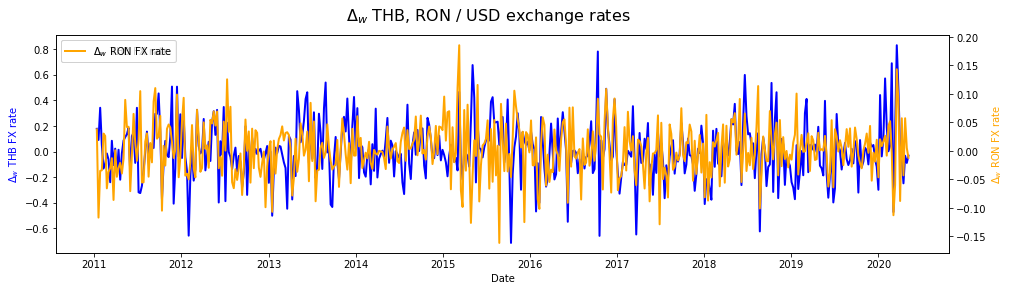

In [106]:
df_ = stat_df[36:36+12]
name = df_[:12].index.values[0][2:9]
plot_pnl(df_[:12], name)

plot_rates('THB', 'RON')
plot_fx('THB', 'RON')

As we can see from the graphs above the **mean highest cumulative PnL** was achieved when trading **5-year bonds** issued by Thailand government. This is due to the fact that **USD has significantly appreciated in terms of both THB and RON** during the investment period, however at the same time we can see that there is no trend of USD appreciation or depreciation in terms of 1-week exchange rates dynamics, thus appreciation of USD don't lead to losses generation. We see a lot of volatility in weekly exchange rates dynamics. This explains a high volatility of daily cumulative PnL.

There were no significant appreciation in THB bond prices even thought 5-year bond prices showed the highest volatility during the investment period.

$$\Downarrow$$

**Contribution to profits:**

- Fixed-float rates spread

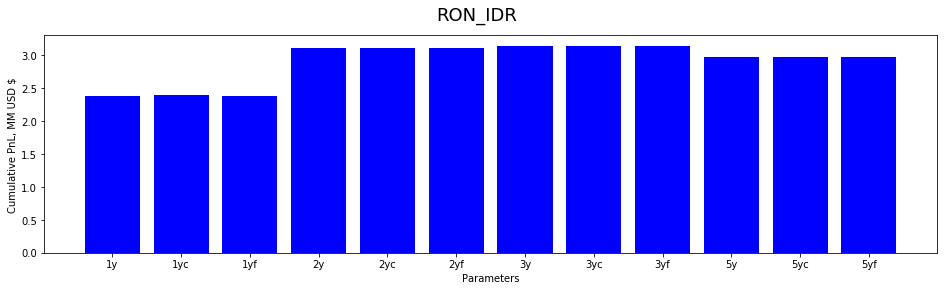

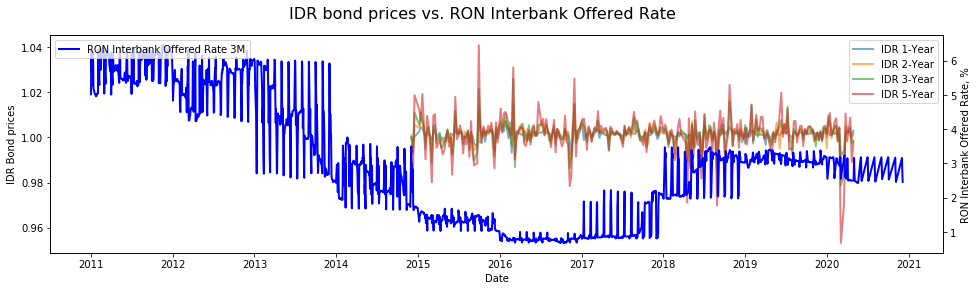

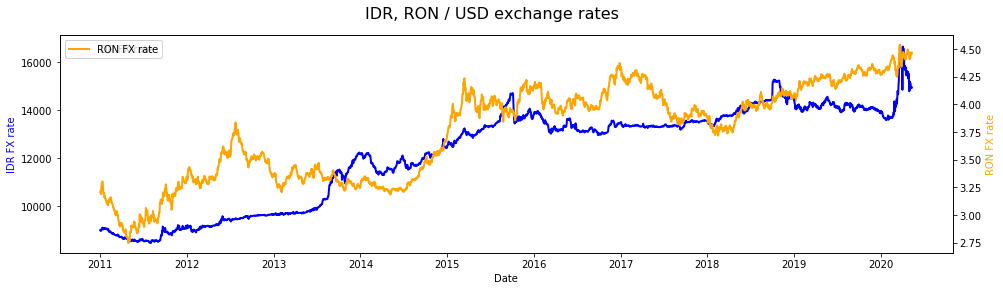

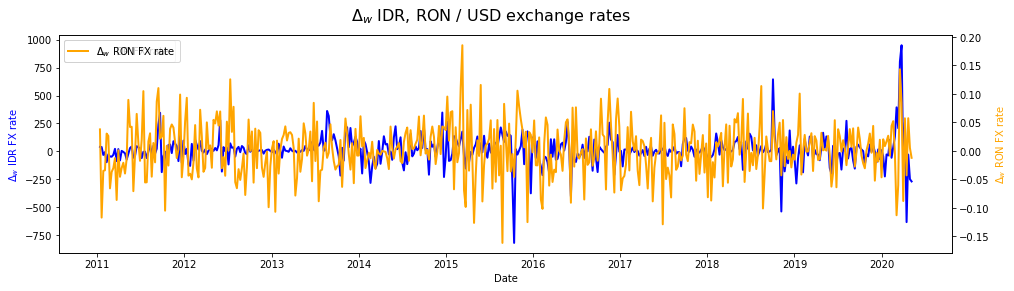

In [110]:
df_ = stat_df[48:48+12]
name = df_[:12].index.values[0][2:9]
plot_pnl(df_[:12], name)

plot_rates('IDR', 'RON')
plot_fx('IDR', 'RON')

As we can see from the graphs above the **mean highest cumulative PnL** was achieved when trading **2, 3 or 5-year bonds** issued by Indonesian government. This is due to the fact that **USD has significantly appreciated in terms of both RON and IDR** during the investment period, however at the same time we can see that there is no trend of USD appreciation or depreciation in terms of 1-week exchange rates dynamics, thus appreciation of USD don't lead to losses generation. We see a lot of volatility in weekly exchange rates dynamics. This explains a high volatility of daily cumulative PnL.

IDR bond prices were rather volatile during the investment period, and this contibutes to profits.

$$\Downarrow$$

**Contribution to profits:**

- Bond Price volatility

- Fixed-float rates gap

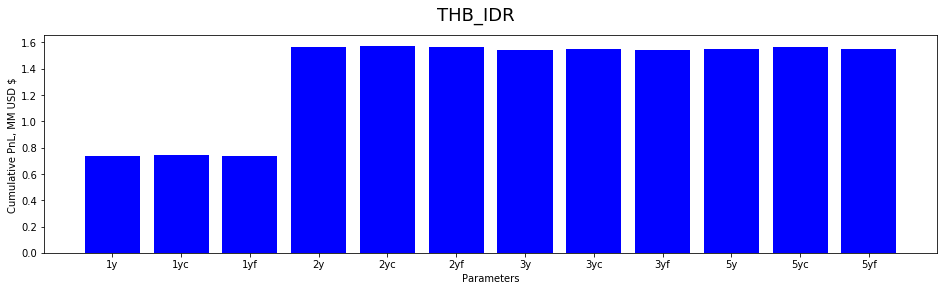

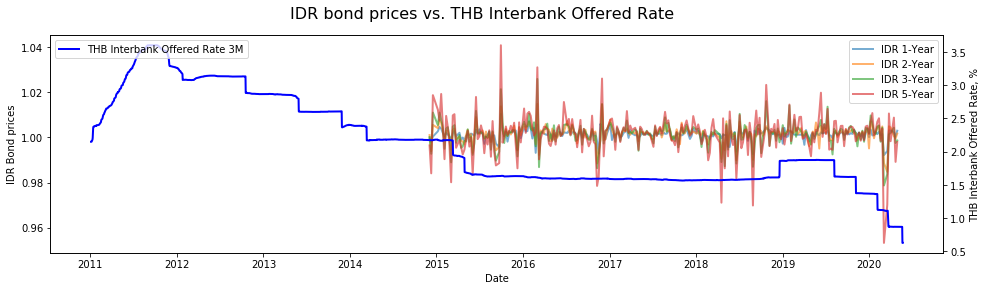

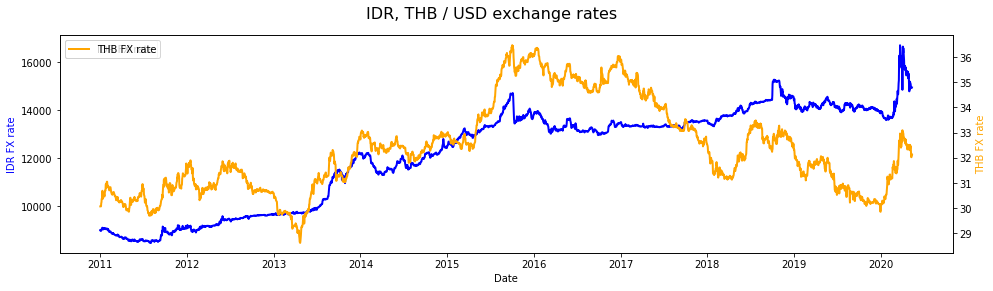

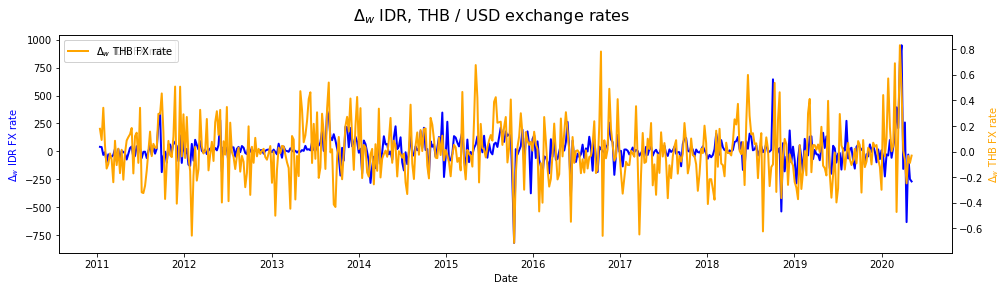

In [111]:
df_ = stat_df[60:60+12]
name = df_[:12].index.values[0][2:9]
plot_pnl(df_[:12], name)

plot_rates('IDR', 'THB')
plot_fx('IDR', 'THB')

As we can see from the graphs above the **mean highest cumulative PnL** was achieved when trading **2, 3 or 5-year bonds** issued by Indonesian government. This is due to the fact that **USD has appreciated in terms of both THB and IDR** during the investment period, however at the same time we can see that there is no trend of USD appreciation or depreciation in terms of 1-week exchange rates dynamics, thus appreciation of USD don't lead to losses generation. We see a lot of volatility in weekly exchange rates dynamics. This explains a high volatility of daily cumulative PnL.

IDR bond prices were rather volatile during the investment period, and this contibutes to profits.

$$\Downarrow$$

**Contribution to profits:**

- Bond Price volatility

- Fixed-float rates gap

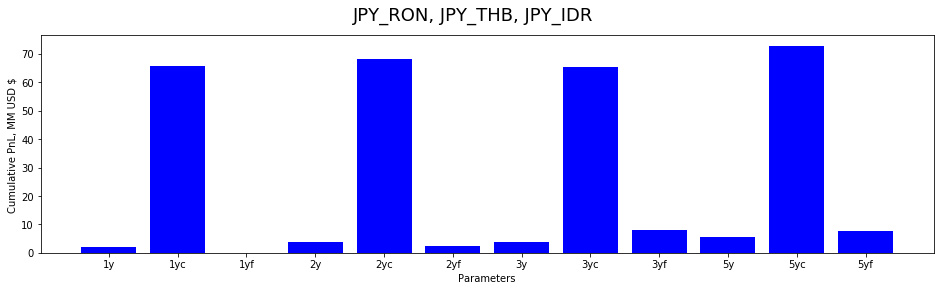

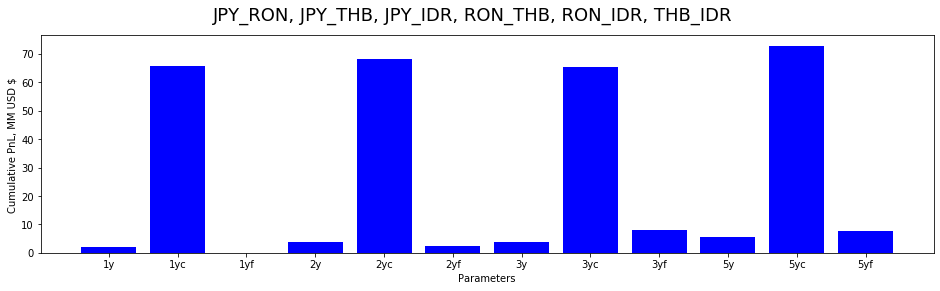

In [112]:
df_ = stat_df[72:72+12]
name = 'JPY_RON, JPY_THB, JPY_IDR'
plot_pnl(df_[:12], name)

df_ = stat_df[72:72+12]
name = 'JPY_RON, JPY_THB, JPY_IDR, RON_THB, RON_IDR, THB_IDR'
plot_pnl(df_[:12], name)

As we can see from the graphs above the **mean highest cumulative PnL** was achieved when simultaneously trading **2, 3 or 5-year bonds** with "ceiling" rounding issued by Indonesian, Thailand and Romanian government while borrowing in JPY, RON and THB. High profits are due to the fact that **USD has appreciated in terms of all currencies, i.e. THB, IDR, RON, JPY** during the investment period, even though we were not able to fully exploit this fact due to weekly position opening/closing. We saw previously that there were no trend of USD appreciation or depreciation in terms of 1-week exchange rates dynamics, thus appreciation of USD don't lead to losses generation. We saw a lot of volatility in weekly exchange rates dynamics. This explains a high volatility of our final daily cumulative PnL.

As we saw from the previous analysis and plots, bond prices were rather volatile and sometimes we were able to exploit bond prices appreciation to lock in profits.   

$$\Downarrow$$

**Contribution to profits:**

- Bond Price volatility

- Fixed-float rates gap

Let us further consider other characteristics of strategy performance, i.e. Sharpe Ratio, Sortino Ratio and Mean Return as well as cumulative statistics.

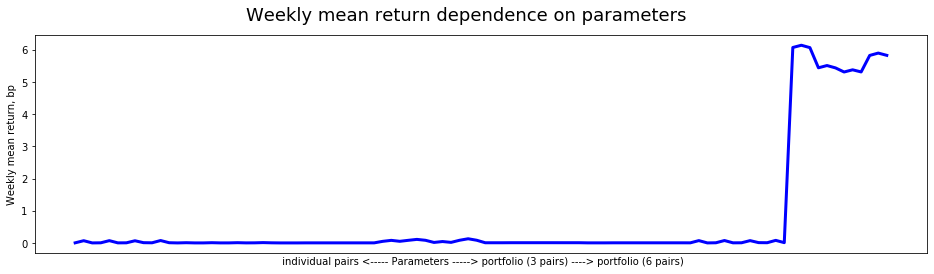

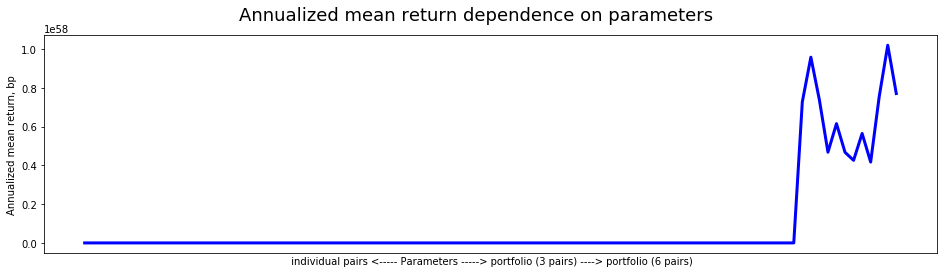

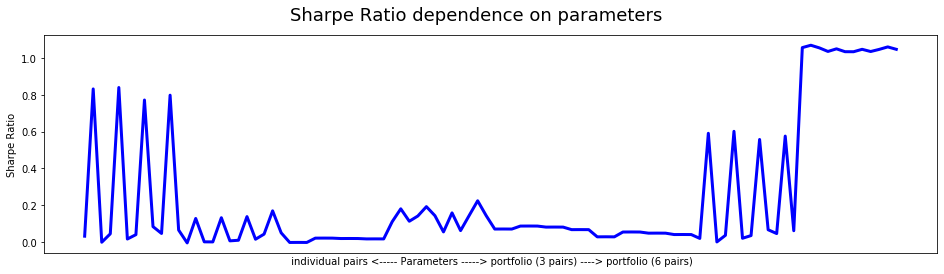

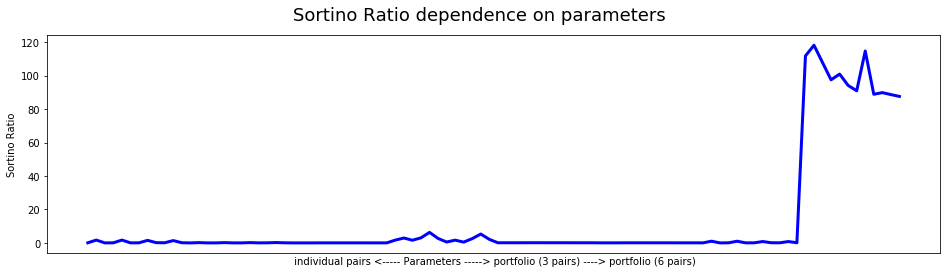

In [26]:
plot_stat(stat_df, 'Wk_ret', 'Weekly mean return, bp', 'Weekly mean return dependence on parameters')
plot_stat(stat_df, 'An_ret', 'Annualized mean return, bp', 'Annualized mean return dependence on parameters')
plot_stat(stat_df, 'SR', 'Sharpe Ratio', 'Sharpe Ratio dependence on parameters')
plot_stat(stat_df, 'SoR', 'Sortino Ratio', 'Sortino Ratio dependence on parameters')

idx_max = stat_df[stat_df['Cum_PnL_USD'] == stat_df['Cum_PnL_USD'].max()].index[0]
idx_max_sr = stat_df[stat_df['SR'] == stat_df['SR'].max()].index[0]
idx_max_sor = stat_df[stat_df['SoR'] == stat_df['SoR'].max()].index[0]
idx_max_wr = stat_df[stat_df['Wk_ret'] == stat_df['Wk_ret'].max()].index[0]
idx_max_ar = stat_df[stat_df['An_ret'] == stat_df['An_ret'].max()].index[0]

idx_min = stat_df[stat_df['Cum_PnL_USD'] == stat_df['Cum_PnL_USD'].min()].index[0]
idx_min_sr = stat_df[stat_df['SR'] == stat_df['SR'].min()].index[0]
idx_min_sor = stat_df[stat_df['SoR'] == stat_df['SoR'].min()].index[0]
idx_min_wr = stat_df[stat_df['Wk_ret'] == stat_df['Wk_ret'].min()].index[0]
idx_min_ar = stat_df[stat_df['An_ret'] == stat_df['An_ret'].min()].index[0]

stat_max = pd.DataFrame(index=['Best', 'Worst'], \
                columns=['Cum_PnL_USD, $ MM', 'Weekly_Mean_Return, bp', 'Sharpe_Ratio', 'Sortino_Ratio'])
stat_max.loc['Best', 'Cum_PnL_USD, $ MM'] = stat_df.loc[idx_max]['Cum_PnL_USD']
stat_max.loc['Best', 'Weekly_Mean_Return, bp'] = stat_df.loc[idx_max_wr]['Wk_ret']
stat_max.loc['Best', 'Sharpe_Ratio'] = stat_df.loc[idx_max_wr]['SR']
stat_max.loc['Best', 'Sortino_Ratio'] = stat_df.loc[idx_max_sor]['SoR']

stat_max.loc['Worst', 'Cum_PnL_USD, $ MM'] = stat_df.loc[idx_min]['Cum_PnL_USD']
stat_max.loc['Worst', 'Weekly_Mean_Return, bp'] = stat_df.loc[idx_min_wr]['Wk_ret']
stat_max.loc['Worst', 'Sharpe_Ratio'] = stat_df.loc[idx_min_wr]['SR']
stat_max.loc['Worst', 'Sortino_Ratio'] = stat_df.loc[idx_min_sor]['SoR']

In [27]:
print('Parameters sorresponding to the BEST performance:\n{}'.format(idx_max))

print('\nParameters sorresponding to the WORST performance:\n{}'.format(idx_min))

stat_max

Parameters sorresponding to the BEST performance:
['JPY_RON', 'JPY_THB', 'JPY_IDR', 'RON_THB', 'RON_IDR', 'THB_IDR']_1-Year_ceil

Parameters sorresponding to the WORST performance:
['JPY_THB']_1-Year_frac


,"Cum_PnL_USD, $ MM","Weekly_Mean_Return, bp",Sharpe_Ratio,Sortino_Ratio
Best,5660.62,6.1395,1.07081,118.239
Worst,-0.134087,-0.000269252,-0.00533215,-0.0070036


As we can see from the table above, the ***WORST PERFORMANCE*** of the strategy is associated with trading only **JPY/THB pair**. And it was an expected fact as we saw on the plots of individual pair above that THB showed the lowest bond price appreciation and volatility. At the same time it showed high exchange rates weekly volatility with a small USD appreciation trend. This contributed to the fact that FX Carry Trade Strategy showed the worst performance when only JPY/THB pair was under consideration.

At the same time, as we can see from the graphs and table above strategy shows the ***BEST PERFORMANCE*** in terms of Cumulative investment period PnL, Sharpe Ratio, Sortino Ratio and Mean Weekly Return when we were trading **all combinations of currency pairs at once**. This can be explained by **HIGH CUMULATIVE LEVERAGE, INCREASED EXPOSURE TO EXCHANGE RATES WEEKLY DYNAMICS  and fixed-float rates gap**.

One of the most interesting observations is that **profits jump when we use "CEILING" rounding for the number of bond prices**, i.e. round 328.56 to 329 and invest in 329 rather than in 328 or 328.56 number of bonds. In such a case we usually invest a bit more than $10 MM and due to the fact that we use **5x leverage** our return jumps dramatically.

In [119]:
stat_dict["['RON_IDR']"]

,THB_B,THB_size,THB_L,RON_B,RON_size,RON_L,JPY_B,JPY_size,JPY_L,IDR_B,IDR_size,IDR_L,USD_B,USD_L,PnL_USD,WkR_USD,AnR_USD,PnL_RON,PnL_THB,PnL_IDR
Date,,,,,,,,,,,,,,,,,,,,
2014-12-10,0.0,0.0,0.0,-0.002981,0.0,0.0,0.0,0.0,0.0,0.0,246212.0,-442.306783,-0.013183,-0.071595,-0.084778,-0.042389,1.045079e-01,-0.002981,0.0,-442.306783
2014-12-17,0.0,0.0,0.0,-0.002940,0.0,0.0,0.0,0.0,0.0,0.0,247098.0,-1971.324305,0.093968,-0.428500,-0.334532,-0.167266,7.160850e-05,-0.002940,0.0,-1971.324305
2015-01-07,0.0,0.0,0.0,-0.002913,0.0,0.0,0.0,0.0,0.0,0.0,254042.0,2380.115815,0.364996,0.201479,0.566475,0.283237,4.440541e+05,-0.002913,0.0,2380.115815
2015-01-14,0.0,0.0,0.0,-0.003037,0.0,0.0,0.0,0.0,0.0,0.0,253688.0,1555.339164,0.037073,0.191725,0.228798,0.114399,2.836836e+02,-0.003037,0.0,1555.339164
2015-01-21,0.0,0.0,0.0,-0.003056,0.0,0.0,0.0,0.0,0.0,0.0,251966.0,928.556346,0.139475,0.137431,0.276906,0.138453,8.638297e+02,-0.003056,0.0,928.556346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-18,0.0,0.0,0.0,-0.003548,0.0,0.0,0.0,0.0,0.0,0.0,284534.0,-6657.142221,0.151294,-1.100254,-0.948960,-0.474480,2.695975e-15,-0.003548,0.0,-6657.142221
2020-03-25,0.0,0.0,0.0,-0.003631,0.0,0.0,0.0,0.0,0.0,0.0,304752.0,-4555.148245,0.150557,-0.868579,-0.718022,-0.359011,8.484824e-11,-0.003631,0.0,-4555.148245
2020-04-01,0.0,0.0,0.0,-0.003664,0.0,0.0,0.0,0.0,0.0,0.0,323758.0,1717.812108,-0.161068,0.205443,0.044374,0.022187,3.140105e+00,-0.003664,0.0,1717.812108


In [120]:
0.102144 + 0.106982

0.20912599999999998

In [ ]:
0.106982

In [123]:
-0.003596 / 4.4604

-0.0008062057214599587

In [125]:
print(fx_df.loc['2020-04-15', 'RON'])
print(fx_df.loc['2020-04-22', 'RON'])

4.403
4.4604


In [135]:
(8*4.403*(1+50/100+2.5/100)/100) / 4.4604

0.12043000627746389

In [132]:
libor['RON'].loc['2020-04-22','LIBOR3M']

2.5

In [136]:
stat_dict.keys()

dict_keys(["['JPY_RON']", "['JPY_THB']", "['JPY_IDR']", "['RON_THB']", "['RON_IDR']", "['THB_IDR']", "['JPY_RON', 'JPY_THB', 'JPY_IDR']", "['JPY_RON', 'JPY_THB', 'JPY_IDR', 'RON_THB', 'RON_IDR', 'THB_IDR']"])

In [137]:
stat_dict["['JPY_THB']"]

,THB_B,THB_size,THB_L,RON_B,RON_size,RON_L,JPY_B,JPY_size,JPY_L,IDR_B,IDR_size,IDR_L,USD_B,USD_L,PnL_USD,WkR_USD,AnR_USD,PnL_RON,PnL_THB,PnL_IDR
Date,,,,,,,,,,,,,,,,,,,,
2014-12-10,0.0,658.0,-0.256259,0.0,0.0,0.0,-0.093118,0.0,0.0,0.0,0.0,0.0,-0.076615,0.013624,-0.062991,-0.031496,1.884943e-01,0.0,-0.256259,0.0
2014-12-17,0.0,656.0,-1.151637,0.0,0.0,0.0,-0.092252,0.0,0.0,0.0,0.0,0.0,0.007129,-0.081698,-0.074570,-0.037285,1.378890e-01,0.0,-1.151637,0.0
2015-01-07,0.0,660.0,4.008961,0.0,0.0,0.0,-0.092343,0.0,0.0,0.0,0.0,0.0,0.050647,0.161115,0.211762,0.105881,1.901437e+02,0.0,4.008961,0.0
2015-01-14,0.0,658.0,0.746366,0.0,0.0,0.0,-0.092945,0.0,0.0,0.0,0.0,0.0,-0.124049,0.057009,-0.067040,-0.033520,1.690099e-01,0.0,0.746366,0.0
2015-01-21,0.0,656.0,-1.949561,0.0,0.0,0.0,-0.091519,0.0,0.0,0.0,0.0,0.0,0.035987,0.003088,0.039075,0.019537,2.742626e+00,0.0,-1.949561,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-18,0.0,628.0,-5.518101,0.0,0.0,0.0,-0.083412,0.0,0.0,0.0,0.0,0.0,-0.027869,-0.471307,-0.499176,-0.249588,3.146133e-07,0.0,-5.518101,0.0
2020-03-25,0.0,648.0,2.193429,0.0,0.0,0.0,-0.083091,0.0,0.0,0.0,0.0,0.0,0.301459,-0.072031,0.229428,0.114714,2.878946e+02,0.0,2.193429,0.0
2020-04-01,0.0,658.0,-1.246082,0.0,0.0,0.0,-0.086385,0.0,0.0,0.0,0.0,0.0,-0.258886,-0.026776,-0.285662,-0.142831,3.235185e-04,0.0,-1.246082,0.0


In [141]:
zb_1w_data['IDR']

,1-Year,2-Year,3-Year,4-Year,5-Year,6-Year,7-Year,8-Year,9-Year,10-Year,15-Year,20-Year,30-Year
2014-12-03,0.99965,1.00105,1.00019,0.999234,0.996443,0.996656,0.997092,0.99454,0.991667,0.992851,0.989494,0.985672,0.974399
2014-12-10,0.997933,0.993941,0.992755,0.988655,0.984073,0.9818,0.979356,0.979,0.976747,0.973281,0.955003,0.959146,0.943225
2014-12-17,1.00037,1.00558,1.01103,1.01798,1.01876,1.02064,1.02171,1.02875,1.03126,1.02148,1.03931,1.04394,1.04561
2015-01-07,1.00273,1.00411,1.00548,1.00874,1.01229,1.01508,1.01626,1.01549,1.01818,1.02177,1.02228,1.02715,1.00743
2015-01-14,1.00463,1.00777,1.01099,1.01309,1.00741,1.02237,1.02648,1.02846,1.03129,1.03188,1.04347,1.05346,1.03966
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,1.00311,1.0044,1.00196,1.00969,0.998324,1.00101,1.00723,1.009,1.0096,1.00295,1.00811,1.0191,1.00693
2020-04-15,1.00215,1.00062,1.00432,1.00868,1.00878,1.00115,1.00953,1.00814,1.00632,1.00767,1.01373,1.01219,1.00338
2020-04-22,1.00041,0.999533,0.997532,0.991295,0.989157,1.00092,0.999648,0.993297,0.99231,0.985592,0.992582,0.999116,1.00534
2020-04-29,1.00298,1.00169,0.998663,1.00224,0.997946,1.00084,0.991416,0.994417,0.994719,0.998191,0.990705,0.990136,1.00035
